<a href="https://colab.research.google.com/github/pamela-cp/Revenue-Fleet-Optimisation/blob/main/notebooks/Revenue_Fleet_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving BuildMax_Rentals_Dataset_Updated_FV.xlsx to BuildMax_Rentals_Dataset_Updated_FV (2).xlsx
Optimal Rental Strategy:
1, Excavators, 1-week weeks: 43.0 rentals
1, Excavators, 4-week weeks: 7.0 rentals
1, Excavators, 8-week weeks: 18.0 rentals
1, Excavators, 16-week weeks: 43.0 rentals
1, Cranes, 1-week weeks: 16.0 rentals
1, Cranes, 4-week weeks: 44.0 rentals
1, Cranes, 8-week weeks: 47.0 rentals
1, Cranes, 16-week weeks: 38.0 rentals
1, Bulldozers, 1-week weeks: 47.0 rentals
1, Bulldozers, 4-week weeks: 34.0 rentals
1, Bulldozers, 8-week weeks: 6.0 rentals
1, Bulldozers, 16-week weeks: 48.0 rentals
2, Excavators, 1-week weeks: 33.0 rentals
2, Excavators, 4-week weeks: 41.0 rentals
2, Excavators, 8-week weeks: 16.0 rentals
2, Excavators, 16-week weeks: 49.0 rentals
2, Cranes, 1-week weeks: 5.0 rentals
2, Cranes, 4-week weeks: 41.0 rentals
2, Cranes, 8-week weeks: 16.0 rentals
2, Cranes, 16-week weeks: 48.0 rentals
2, Bulldozers, 1-week weeks: 44.0 rentals
2, Bulldozers, 4-week weeks

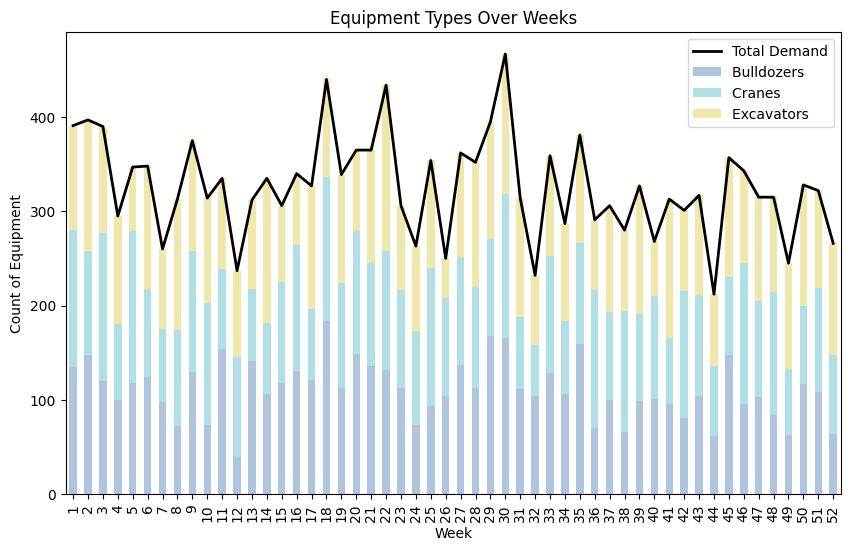

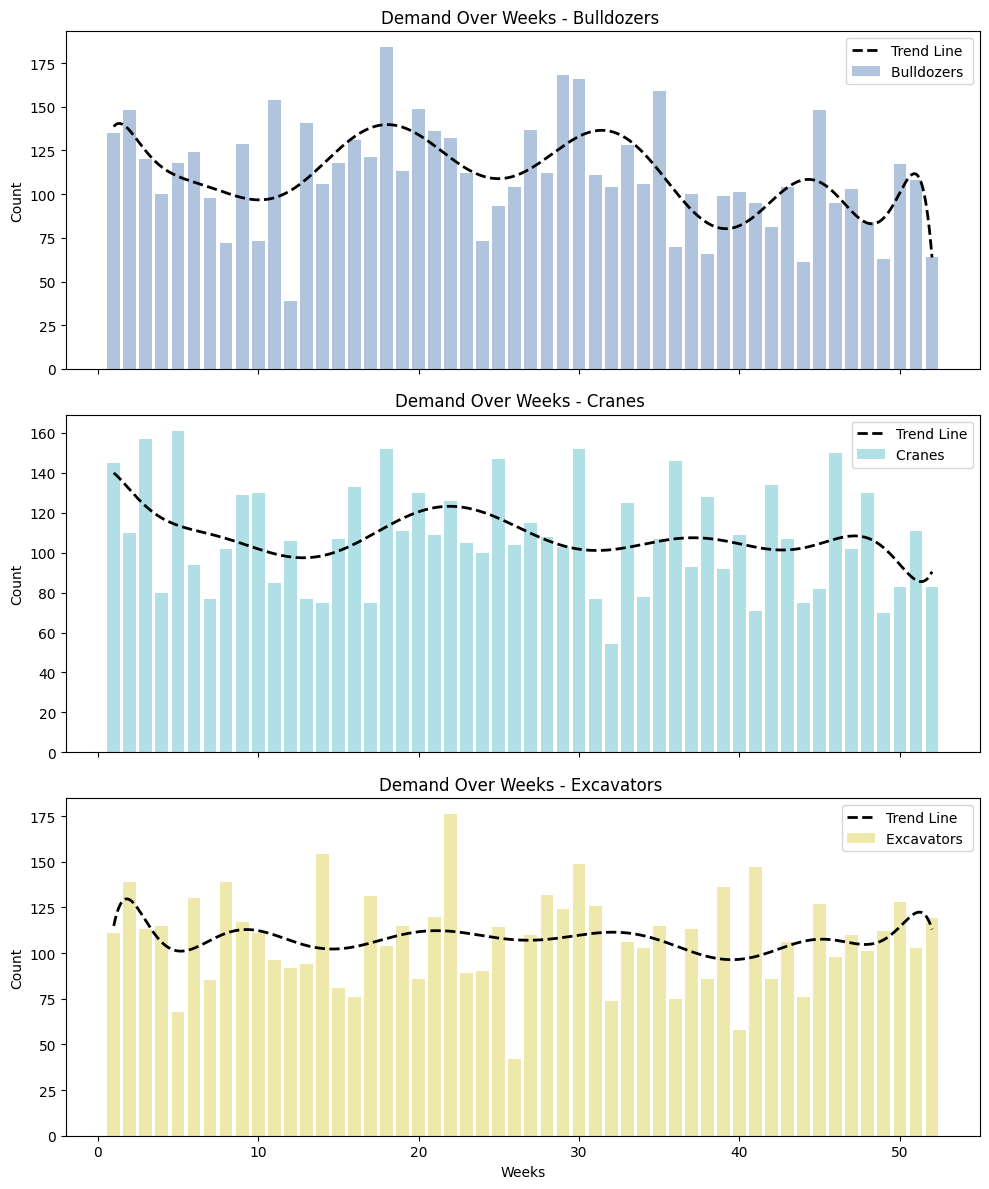

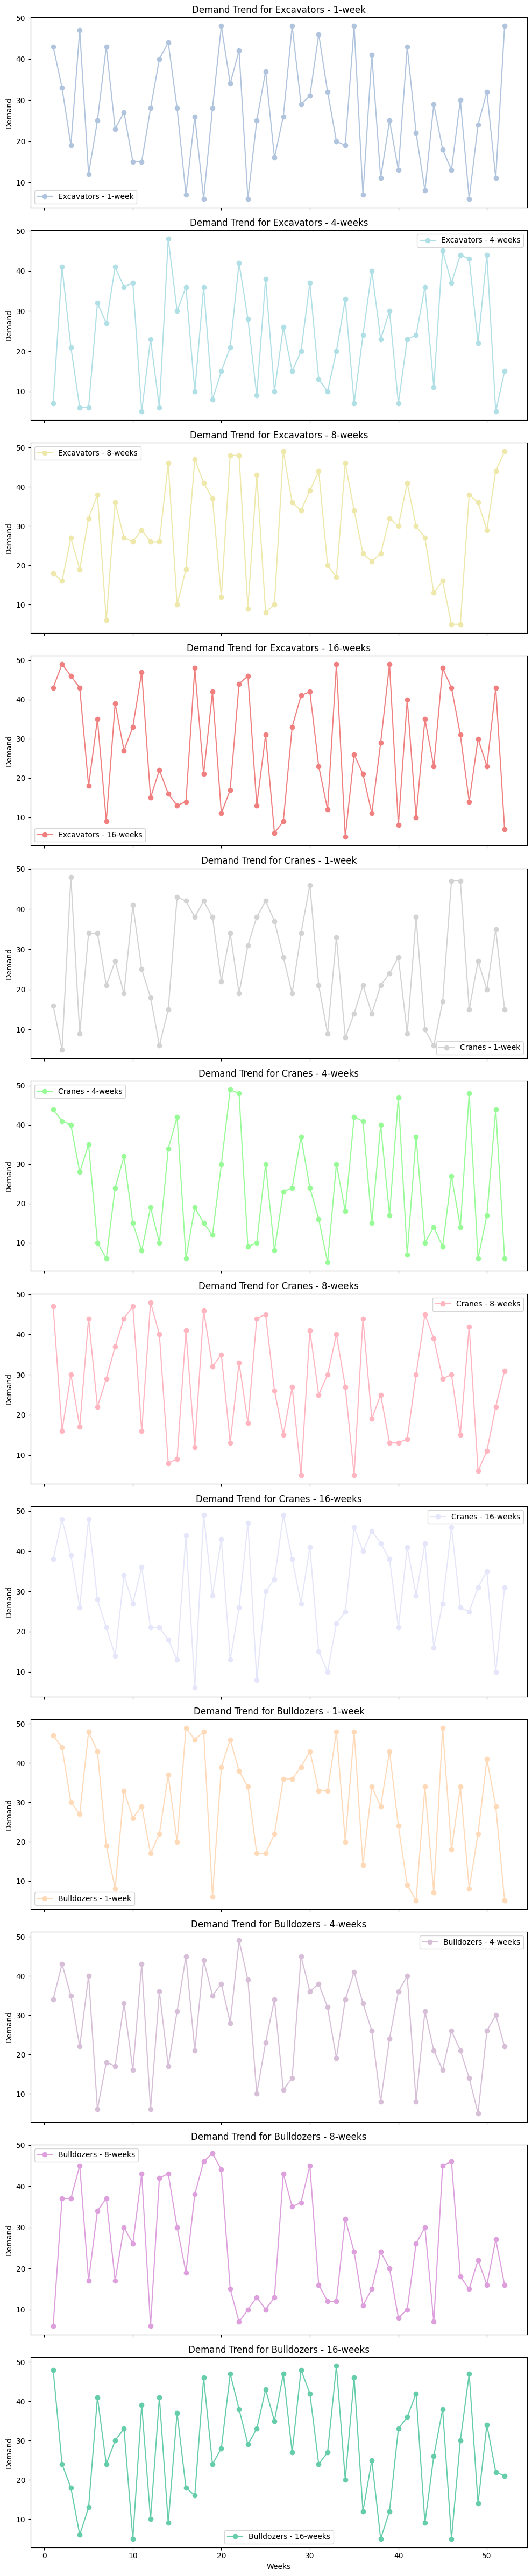

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""

"""

import pandas as pd
import numpy as np
from pyomo.environ import *
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Loading data

from google.colab import files
uploaded = files.upload()

# Install glpk solver
!apt-get install -y -qq glpk-utils

# Import data
matrix_demand_forecast = pd.read_excel("BuildMax_Rentals_Dataset_Updated_FV.xlsx", sheet_name="Demand_Forecast")
matrix_prices = pd.read_excel("BuildMax_Rentals_Dataset_Updated_FV.xlsx", sheet_name="Prices")
matrix_equipment = pd.read_excel("BuildMax_Rentals_Dataset_Updated_FV.xlsx", sheet_name="Equipment")
matrices_list = [matrix_demand_forecast, matrix_prices]

# Define products and rental week lengths
equipment = matrix_equipment['Type_Equipment'].unique()
length_lease = matrix_equipment['Length_lease'].unique()
weeks = matrix_demand_forecast['Week'].unique()

n_equipment=len(equipment)
n_leases=len(length_lease)
n_weeks=len(weeks)

# -----------------------------------------------------------------------------
# INPUTS MODEL
# -----------------------------------------------------------------------------

# Extract price, accepted units, demand, and inventory columns

prices = np.zeros((n_weeks, n_equipment, n_leases))
demand = np.zeros((n_weeks, n_equipment, n_leases))
returns = np.zeros((n_weeks, n_equipment, n_leases))
capacity = matrix_equipment.iloc[:,1].dropna(axis=0)

accepted = np.zeros((n_weeks, n_equipment, n_leases))
inventory = np.zeros((n_weeks, n_equipment, n_leases))

i,j=0,0
for i, equip in enumerate(equipment):                                   # For equipment (e.g. excavators)
    for j, lease in enumerate(length_lease):                            # For duration lease (e.g. 1-week)
        for m,matrix in enumerate(matrices_list):
            for col in matrix.columns:                                  # Loop in all columns
                if equip in col and lease in col:                       # match excavators and 1-week with headline of column
                    col_index=matrix.columns.get_loc(col)
                    if m==0:
                        for row in matrix.index:
                            demand[row,i,j]=matrix.iloc[row,col_index]
                    if m==1:
                        for row in matrix.index:
                            prices[row,i,j]=matrix.iloc[row,col_index]

# -----------------------------------------------------------------------------
# BUILD MODEL
# -----------------------------------------------------------------------------


# Define model
model = ConcreteModel()

# Define decision variables
model.x = Var(range(n_weeks),range(n_equipment),range(n_leases), domain=NonNegativeIntegers)

# Define variable
model.inventory_i = Var(range(n_weeks),range(n_equipment), domain=NonNegativeIntegers)

model.inventory_f = Var(range(n_weeks),range(n_equipment), domain=NonNegativeIntegers)

model.used_equipment = Var(range(n_weeks),range(n_equipment), domain=NonNegativeIntegers)

model.revenue_equipment = Var(range(n_weeks),range(n_equipment),range(n_leases), domain=NonNegativeReals)

# Define objective function: Maximize revenue

def revenue_rule(model):
    return sum(prices[k,i,j] * model.x[k,i,j] * (7 * int(length_lease[j].split("-")[0])) for k in range(n_weeks) for i in range(n_equipment) for j in range(n_leases))
model.revenue = Objective(rule= revenue_rule, sense=maximize)  # Maximize revenue

# Constraints

def demand_constraint(model, k, i, j):
    return model.x[k,i,j] <= demand[k,i,j]
model.demand_constraint = Constraint(range(n_weeks),range(n_equipment),range(n_leases), rule=demand_constraint)

def capacity_constraint(model, k, i):
    return sum(model.x[k,i,j] for j in range(n_leases)) + sum(model.x[u,i,j] for u in range(k) for j in range(n_leases) if u+int(length_lease[j].split("-")[0])>k)  <= capacity.iloc[i]
model.capacity_constraint = Constraint(range(n_weeks),range(n_equipment), rule=capacity_constraint)

def inventory_i_constraint(model, k, i):
    if k == 0:
        return model.inventory_i[k, i] == capacity.iloc[i]  # Initial inventory
    else:
        return model.inventory_i[k, i] == model.inventory_i[k-1, i] + sum(model.x[u,i,j] for u in range(k) for j in range(n_leases) if u+int(length_lease[j].split("-")[0])==k) - sum(model.x[k-1, i, j] for j in range(n_leases))
model.inventory_i_constraint = Constraint(range(n_weeks), range(n_equipment), rule=inventory_i_constraint)

def inventory_f_constraint(model, k, i):
    if k == 0:
        return model.inventory_f[k, i] == capacity.iloc[i] - sum(model.x[k, i, j] for j in range(n_leases))  # Initial inventory
    else:
        return model.inventory_f[k, i] == model.inventory_f[k-1, i] + sum(model.x[u,i,j] for u in range(k) for j in range(n_leases) if u+int(length_lease[j].split("-")[0])==k) - sum(model.x[k, i, j] for j in range(n_leases))
model.inventory_f_constraint = Constraint(range(n_weeks), range(n_equipment), rule=inventory_f_constraint)

def used_equipment_constraint(model, k, i):
    return model.used_equipment[k, i] == sum(model.x[u,i,j] for u in range(k+1) for j in range(n_leases) if u+int(length_lease[j].split("-")[0])>k)
model.used_equipment_constraint = Constraint(range(n_weeks), range(n_equipment), rule=used_equipment_constraint)

def revenue_equipment_constraint(model, k, i, j):
    return model.revenue_equipment[k, i, j] == (
        prices[k, i, j] * model.x[k,i,j] * 7 * int(length_lease[j].split("-")[0])
    )
model.revenue_equipment_constraint = Constraint(range(n_weeks), range(n_equipment),range(n_leases), rule=revenue_equipment_constraint)


# Solve the optimization problem
solver = SolverFactory("glpk", executable="/usr/bin/glpsol")
results=solver.solve(model)

# Print results
print("Optimal Rental Strategy:")
for k in range(n_weeks):
    for i in range(n_equipment):
        for j in range(n_leases):
            print(f"{weeks[k]}, {equipment[i]}, {length_lease[j]} weeks: {model.x[k, i, j].value} rentals")

print(f"\nTotal Revenue: £{model.revenue()} ")


# Extract decision variable values for rentals
data_rentals = []
for index in model.x.keys():
    data_rentals.append([weeks[index[0]], f"{equipment[index[1]]}_{length_lease[index[2]]}", model.x[index].value])

# Convert to DataFrame
df_rentals = pd.DataFrame(data_rentals, columns=['Week', 'Equipment_Lease', 'Value'])

# Pivot table for rentals
df_rentals_pivot = df_rentals.pivot(index='Week', columns='Equipment_Lease', values='Value')


# Extract initial inventory values from the model
data_inventory_i = []
for k in range(n_weeks):
    for i in range(n_equipment):
        data_inventory_i.append([weeks[k], equipment[i], model.inventory_i[k, i].value])

# Convert initial inventory to DataFrame
df_inventory_i = pd.DataFrame(data_inventory_i, columns=['Week', 'Equipment', 'Inventory_Value'])

# Pivot table for initial inventory
df_inventory_i_pivot = df_inventory_i.pivot(index='Week', columns='Equipment', values='Inventory_Value')


# Extract final inventory values from the model
data_inventory_f = []
for k in range(n_weeks):
    for i in range(n_equipment):
        data_inventory_f.append([weeks[k], equipment[i], model.inventory_f[k, i].value])

# Convert initial inventory to DataFrame
df_inventory_f = pd.DataFrame(data_inventory_f, columns=['Week', 'Equipment', 'Inventory_Value'])

# Pivot table for initial inventory
df_inventory_f_pivot = df_inventory_f.pivot(index='Week', columns='Equipment', values='Inventory_Value')


# Extract used equipment values from the model
data_used_equipment = []
for k in range(n_weeks):
    for i in range(n_equipment):
        data_used_equipment.append([weeks[k], equipment[i], model.used_equipment[k, i].value])

# Convert used equipment to DataFrame
df_used_equipment = pd.DataFrame(data_used_equipment, columns=['Week', 'Equipment', 'Used_Equipment_Value'])

# Pivot table for used equipment
df_used_equipment_pivot = df_used_equipment.pivot(index='Week', columns='Equipment', values='Used_Equipment_Value')


# Calculate revenue
data_revenue = []
for index in model.revenue_equipment.keys():
    data_revenue.append([weeks[index[0]], f"{equipment[index[1]]}_{length_lease[index[2]]}", model.revenue_equipment[index].value])

# Convert to DataFrame
df_revenue = pd.DataFrame(data_revenue, columns=['Week', 'Equipment_Lease', 'Value'])

# Pivot table for rentals
df_revenue_pivot = df_revenue.pivot(index='Week', columns='Equipment_Lease', values='Value')


# Save both rental and inventory data to an Excel file with multiple sheets
output_filename = "optimisation_model_results.xlsx"
with pd.ExcelWriter(output_filename) as writer:
    df_rentals_pivot.to_excel(writer, sheet_name="Rentals")
    df_inventory_i_pivot.to_excel(writer, sheet_name="Initial_Inventory")
    df_inventory_f_pivot.to_excel(writer, sheet_name="Final_Inventory")
    df_used_equipment_pivot.to_excel(writer, sheet_name="Used_Equipment")
    df_revenue_pivot.to_excel(writer, sheet_name="Revenue")

print(f"Results saved successfully in {output_filename}")

# # Validating solution:

# print("\nDetailed Constraints:")
# for constr_name in model.component_objects(Constraint, active=True):
#     print(f"\nConstraint: {constr_name}")
#     constraint_data = getattr(model, str(constr_name))
#     for index in constraint_data:
#         print(f"  {index}: {constraint_data[index].expr}")  # Prints constraint formula

# -----------------------------------------------------------------------------
# PLOTS
# -----------------------------------------------------------------------------


# FIRST PLOT

# Extract the equipment type from the column names
equipment_types = matrix_demand_forecast.columns.str.split('-').str[0]

# Sum the columns with the same equipment type
demand_equipment = matrix_demand_forecast.T.groupby(equipment_types).sum().T

# Set 'Week' as the index for better plotting
demand_equipment = demand_equipment.set_index('Week')

# Calculate total demand
total_demand = demand_equipment.sum(axis=1)

# Define colors for each equipment type
colors = ['lightsteelblue', 'powderblue', 'palegoldenrod', 'lightcoral',
          'lightgrey', 'palegreen', 'lightpink', 'lavender',
          'peachpuff', 'thistle', 'plum', 'mediumaquamarine']


# Create the plot for equipment types
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bar chart for equipment types (stacked bars)
demand_equipment.plot(kind='bar', color=colors, stacked=True, ax=ax)

# Plot the overall trend (total demand) as a line, ensuring the x-axis matches the weeks
ax.plot(range(len(total_demand)), total_demand.values, color='black', linewidth=2, label='Total Demand')

# Set the x-ticks to be the same as the weeks, ensuring proper alignment
ax.set_xticks(range(len(total_demand)))
ax.set_xticklabels(total_demand.index)

# Set title and labels
ax.set_title("Equipment Types Over Weeks")
ax.set_xlabel("Week")
ax.set_ylabel("Count of Equipment")

# Display the legend
ax.legend()

# Show the plot
plt.show()



# SECOND PLOT

# Create separate subplots for each equipment type
fig, axes = plt.subplots(n_equipment, 1, figsize=(10, 12), sharex=True)

# Bulldozers Plot
for a in range(n_equipment):

    # Get X (weeks) and Y (demand data)
    x = np.array(demand_equipment.index)
    y = np.array(demand_equipment.iloc[:, a])

    # Fit a 3rd-degree polynomial to the data
    poly_coeffs = np.polyfit(x, y, deg=12)
    poly = np.poly1d(poly_coeffs)

    # Generate smooth trendline data
    x_smooth = np.linspace(x.min(), x.max(), 1000)  # More points for smoothness
    y_smooth = poly(x_smooth)

    # Bar plot for demand
    axes[a].bar(demand_equipment.index, demand_equipment.iloc[:,a], color=colors[a], label=demand_equipment.columns[a])

    # Plot the non-linear trend line
    axes[a].plot(x_smooth, y_smooth, color='black', linestyle='dashed', linewidth=2, label="Trend Line")

    axes[a].set_ylabel("Count")
    axes[a].set_title(f"Demand Over Weeks - {demand_equipment.columns[a]}")
    axes[a].legend()

plt.xlabel("Weeks")
plt.tight_layout()
plt.show()


# THIRD PLOT

demand_equipment_lease=matrix_demand_forecast.set_index('Week')

# Create subplots for each column
num_cols = len(demand_equipment_lease.columns)
fig, axes = plt.subplots(num_cols, 1, figsize=(10, 4 * num_cols), sharex=True)

for i, col in enumerate(demand_equipment_lease.columns):
    axes[i].plot(demand_equipment_lease.index, demand_equipment_lease[col],color=colors[i], marker='o', linestyle='-', label=col)
    axes[i].set_title(f"Demand Trend for {col}")
    axes[i].set_ylabel("Demand")
    axes[i].legend()

# X-axis Label (shared)
axes[-1].set_xlabel("Weeks")

plt.tight_layout()
plt.show()